## Homework
Choose a different dataset (MNIST, FashioMNIST, CIFAR100, ...) and train you own
model by subclassing nn.Module, as I did in notebook 05.

Optional: scramble it and observe if there is a significant change in performance.

For any question, contact me by email.



**Solution.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cpu


In [2]:
def imshow(img):
    img = img/2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2 , 0)))
    plt.show()
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

def get_accuracy(dataloader, model, device="cpu"):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim = 1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

In [3]:
# import MNIST

#trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                      download=True, transform = transforms.ToTensor())
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=28, shuffle=True)

#testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                     download=True, transform=transforms.ToTensor())
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
#classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
#               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

In [4]:
# import Fashion MNIST

#trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, 
#                                          download=True, transform=transforms.ToTensor())
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=28, shuffle=True)

#testset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
#                                          download=True, transform=transforms.ToTensor())
#testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

#classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
#               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# import STL10

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The download takes a very very long time!
trainset = torchvision.datasets.STL10(root='./data', split='train',
                                      download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
nclasses = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(trainset)

Dataset STL10
    Number of datapoints: 5000
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [7]:
print("trainset.data type: {}".format(type(trainset.data)))
dim = tuple(trainset[0][0].shape)
inputdim = dim[0] * dim[1] * dim[2]
print("images shape: {}".format(dim))

trainset.data type: <class 'numpy.ndarray'>
images shape: (3, 96, 96)


torch.Size([32, 3, 96, 96]) torch.Size([32])


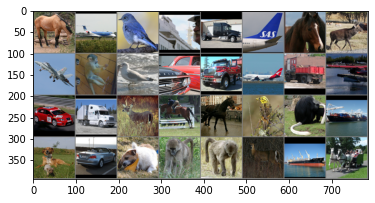

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [9]:
n_hidden = 100

class FCnn(nn.Module):
    def __init__(self, inputdim, nclasses):
        super(FCnn, self).__init__()
        self.input_dim = inputdim
        self.n_classes = nclasses
        self.fc1 = nn.Linear(self.input_dim, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, self.n_classes)
        
    def forward(self, x):
        x = x.view(-1, self.input_dim) # flattening
        x = F.relu(self.fc1(x))
        #x = F.hardtanh(self.fc1(x))
        #x = F.leaky_relu(self.fc1(x))
        x = F.relu(self.fc2(x)) # test acc = 0.408625
        #x = F.hardtanh(self.fc2(x))  # test acc = 0.36375 -> WORSE
        #x = F.leaky_relu(self.fc2(x)) # test acc = 0.10 -> THE WORST
        x = self.out(x) # we want a raw score for the CELoss
        return x
    
net = FCnn(inputdim, nclasses)
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)

horse airplane  bird  ship truck airplane horse  deer airplane monkey  bird   car truck airplane truck airplane   car truck  deer horse horse  bird monkey  ship   dog   car   dog monkey monkey  deer  ship horse
# of parameters: 2776010
FCnn(
  (fc1): Linear(in_features=27648, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


In [10]:
# net.state_dict()

In [11]:
lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

In [12]:
epochs = 50

n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 49, [BATCH]: 150/157, [LOSS]: 0.006012363359332085


In [13]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 1.0
Test accuracy: 0.403


### Scrambled dataset

In [14]:
def scramble_image(tensor, indices):
    tensor = tensor.view(-1)[indices].view(dim[0], dim[1], dim[2])
    return tensor

indices = np.arange(inputdim)
np.random.shuffle(indices)

In [15]:
# import STL10

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda tens: scramble_image(tens, indices))])

# The download takes a very long time!
trainset = torchvision.datasets.STL10(root='./data', split='train',
                                      download=False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                     download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

torch.Size([32, 3, 96, 96]) torch.Size([32])


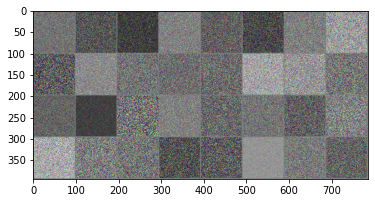

  cat   cat airplane  deer horse   car monkey  ship   car horse   car horse monkey airplane   cat monkey  deer  bird truck   cat monkey monkey airplane   cat horse truck monkey   car  bird airplane airplane monkey


In [16]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [17]:
net = FCnn(inputdim, nclasses)
net.to(device)

lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

epochs = 50

n_batches = len(trainloader)
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 49, [BATCH]: 150/157, [LOSS]: 0.004497954156249762


In [18]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 1.0
Test accuracy: 0.40225
